In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load the data from 25 example trajectories

In [2]:
time_log = []
pot_log = []
toteng_log = []

all_midpoints = []

all_order = []

all_coord = []
all_temp = []
all_dens = []
all_time = []

resultsrange = range(1,26)  ## edit this with how many files to take

for j in resultsrange:
    with open("log-"+str(j)+".lammps", "r") as stream:
        contents = list(stream)
    for i in range(len(contents)):
        if "Step PotEng TotEng Temp Atoms Volume Press Pxx Pyy Pzz Lx Ly Lz" in contents[i]:
            start = i
        if "Loop" in contents[i]:
            stop = i
        if "variable hbh equal" in contents[i]:
            boxcentre = i
    
    all_midpoints.append(eval(contents[boxcentre].split()[-1])-2)  # for System (2b) 'midpoint' = centre of hot thermostat

    data = loadtxt(contents[start+1:stop])
    timestep = data[:,0]
    time_log.append(timestep*2)
    pot_log.append(data[:,1])
    toteng_log.append(data[:,2])
    
    
    # extract order profiles
    
    with open('order-param-'+str(j)+'.lammps', 'r') as stream:
        contents = list(stream)
    delims = []
    for i in range(len(contents)):
        if len(contents[i].split())==3:
            delims.append(i)
    order = []
    x = 0
    while x < len(delims):
        if x == len(delims)-1:
            data_split = loadtxt(contents[delims[x]+1:])
        else:
            data_split = loadtxt(contents[delims[x]+1:delims[x+1]])
        order.append(data_split[:,3])
        x = x+1
    all_order.append(order)
    
    
    
    # density and temperature profiles were dumped separately for oxygen/hydrogen atoms
    
    
    with open('temp-ox-'+str(j)+'.lammps', 'r') as stream:
        contents = list(stream)
    coord = []
    temp_ox = []
    dens_ox = []
    timestep = []
    delims = []
    for i in range(len(contents)):
        if len(contents[i].split())==3:
            delims.append(i)
    x = 0
    while x < len(delims):
        timestep.append(contents[delims[x]].split()[0])
        #data_split = loadtxt(contents[delims[x]+1:delims[x]+195])
        if x == len(delims)-1:
            data_split = loadtxt(contents[delims[x]+1:])
        else:
            data_split = loadtxt(contents[delims[x]+1:delims[x+1]])
        coord.append(data_split[:,1])
        temp_ox.append(data_split[:,3])
        dens_ox.append(data_split[:,4])
        x = x+1
    time = loadtxt(timestep)*2
    
    all_coord.append(coord)
    all_time.append(time)
    
    with open('temp-hy-'+str(j)+'.lammps', 'r') as stream:
        contents = list(stream)
    temp_hy = []
    dens_hy = []

    delims = []
    for i in range(len(contents)):
        if len(contents[i].split())==3:
            delims.append(i)

    x = 0
    while x < len(delims):
        if x == len(delims)-1:
            data_split = loadtxt(contents[delims[x]+1:])
        else:
            data_split = loadtxt(contents[delims[x]+1:delims[x+1]])
        temp_hy.append(data_split[:,3])
        dens_hy.append(data_split[:,4])
        x = x+1
    
       
    # combine oxygen/hydrogen temperature/density profiles
    
    temp = []
    dens = []
    for i in range(len(temp_ox)):
        temp.append((temp_ox[i]+2*temp_hy[i])/3)
        dens.append((dens_ox[i]+dens_hy[i]))
    temp = np.array(temp)
    dens = np.array(dens)
    
    all_temp.append(temp)
    all_dens.append(dens)


# define a function to average temperature/order/density profiles over 
# timesteps with different numbers of bins

def profile_group(A, avg_start, avg_end):
    lengths = []
    first_coords = []
    for i in range(avg_start, avg_end):
        lengths.append(len(all_coord[A][i]))
        first_coords.append(all_coord[A][i][0])
    # desired range is max(first_coords) with (min(lengths)-1) elements
    endrange = min(lengths)-1
    temp_toavg = []
    coord_toavg = []
    dens_toavg = []
    order_toavg = []
    for i in range(avg_start, avg_end):
        for j in range(len(all_coord[A][i])):
            if all_coord[A][i][j] == max(first_coords):
                startpoint = j
        endpoint = startpoint + min(lengths) -1
        coord_toavg.append(all_coord[A][i][startpoint:endpoint])
        temp_toavg.append(all_temp[A][i][startpoint:endpoint])
        dens_toavg.append(all_dens[A][i][startpoint:endpoint])
        order_toavg.append(all_order[A][i][startpoint:endpoint])
    avg_temp = mean(temp_toavg, axis=0)
    avg_coord = mean(coord_toavg, axis=0)
    avg_dens = mean(dens_toavg, axis=0)
    avg_order = mean(order_toavg, axis=0)
    return [avg_coord, avg_temp, avg_order, avg_dens]

# Define the analysis script function

In [3]:
#  This function computes the melting dynamics trajectory for individual simulation runs.
#  "A" is the integer of the individual simulation run, e.g. from range 1-25.
#  'Time' contains 25 arrays of individual times from each simulation
#  'Order' contains 25 arrays of individual order profiles
#   mids contains 25 midpoint values from log files


def Ih_sys2b_melting_kinetics(A, time, order, mids):
    
    # for system (2b), 'midpoints' = centre of hot thermostat
    midpoints = []
    j=0
    while j< len(order[A]):
        midpoints.append(mids[A])
        j=j+20
    midpoints = np.array(midpoints)

    # Find the position of the interface at each timestep
    interface_2 = []
    timerange = []
    int2temp = []
    j=0
    cycle = 0
    while j < len(order[A]):
        
        # Take an average of 20 temperature/order/density profiles
        part = profile_group(A, j, j+20)
        timerange.append(mean(time[A][j:j+20]))
        
        
        # Only take the region between hot:cold thermostats, at lx/4 and 3/4lx respectively
        b = len(part[0])
        split_order = part[2][int(0.25*b):int(0.75*b)]
        split_coord = part[0][int(0.25*b):int(0.75*b)]

        # Define coordinates as either solid or liquid-like
        # Interested in the coexistence region to fit the order profile and find interface
        solid = []
        liquid = []
        coex_coord = []
        coex_ord = []
        coex_elements = []
        for i in range(len(split_order)):
            if split_order[i] < 0.17: # Solid cutoff for ice Ih
                solid.append(split_coord[i])
            if split_order[i] > 0.22: # Liquid cutoff for ice Ih
                liquid.append(split_coord[i])
            if 0.17 < split_order[i] < 0.22:
                coex_coord.append(split_coord[i])
                coex_ord.append(split_order[i])    
                coex_elements.append(i)
        
        # Check if there are enough points in coexistence region for linear fit
        # If not, add the last point of liquid and the first point of solid
        if len(coex_coord)<2:
            if len(coex_elements)>0:
                coex_coord.append(split_coord[coex_elements[0]-1])
                coex_coord.append(split_coord[coex_elements[-1]+1])
                coex_ord.append(split_order[coex_elements[0]-1])
                coex_ord.append(split_order[coex_elements[-1]+1])
                
        # Check again if there are enough points in coexistence region for linear fit
        # If not, take the midpoint between the edges of liquid and solid regions
        if len(coex_coord) < 2:
            interface_2.append(liquid[-1]+(solid[0]-liquid[-1])/2)
            interfaceslice = liquid[-1]+(solid[0]-liquid[-1])/2        
        # Linear fit to find position of interface
        else:
            fit = polyfit(coex_coord, coex_ord, 1)
            m = fit[0]
            c = fit[1]
            # At what coordinate does the line cross 0.230, the ice VI interface order parameter value
            interface_2.append((0.189-c)/m)
            interfaceslice = (0.189-c)/m


        ##Find the interfacial temperature

        split_temp = part[1][int(0.25*b):int(0.75*b)]
        select_coords = []
        select_temp = []
        # Take a selection of coordinates around the position of the interface and fit the temperature profile with polynomial
        for i in range(len(split_coord)):
            if interfaceslice-30<split_coord[i]<interfaceslice+30:
                select_coords.append(split_coord[i])
                select_temp.append(split_temp[i])
        shiftcoords = select_coords - select_coords[0]
        tempfit = polyfit(shiftcoords, select_temp, 8)
        int2temp.append(polyval(tempfit, interfaceslice-select_coords[0]))
        j = j+20
        cycle = cycle+1
    # Find the propagation of the interface at each timestep
    s_2 = interface_2-midpoints

    timerange = np.array(timerange)
    return [timerange, s_2, int2temp]

# Obtain melting trajectories

In [4]:
# Calculate melting trajectories for all 25 runs

t = []
s = []
T = []
for i in range(len(resultsrange)):
    if i%5 == 0:
        print(i, ' of total ', str(len(resultsrange)), ' complete')
    part = Ih_sys2b_melting_kinetics(i, all_time, all_order, all_midpoints)
    t.append(part[0])
    s.append(part[1])
    T.append(part[2])
    
mean_t = mean(t, axis=0)
mean_s = mean(s, axis=0)
std_s = std(s, axis=0)
mean_T = mean(T, axis=0)
std_T = std(T, axis=0)

print('Analysis finished')

# at this stage, t in units of fs, s in units of A, T in units of K

0  of total  25  complete
5  of total  25  complete
10  of total  25  complete
15  of total  25  complete
20  of total  25  complete
Analysis finished


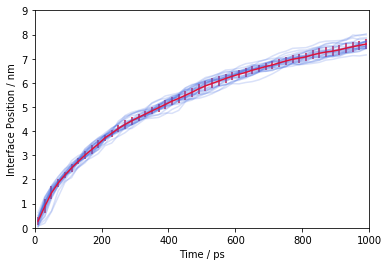

In [5]:
# plot the melting trajectories: interfacial position
# all individual runs plotted for demonstration purposes, as well as the mean trajectory
# error bars correspond to std across individual runs
for i in range(len(resultsrange)):
    plot(t[i]*1e-3, s[i]/10, color='royalblue', alpha=0.2)
plot(mean_t*1e-3, mean_s/10, marker='', linestyle='-', color='crimson')
errorbar(mean_t*1e-3, mean_s/10, yerr=std_s/10, linestyle='', color='crimson')
xlabel('Time / ps')
ylabel('Interface Position / nm')
ylim(0,9)
xlim(0,1000)
show()

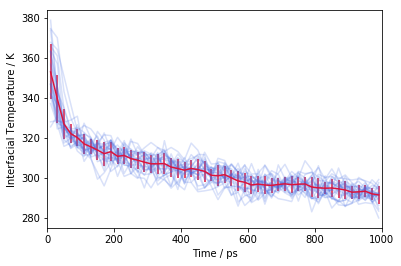

In [6]:
# plot the melting trajectories: interfacial temperature
# all individual runs plotted for demonstration purposes, as well as the mean trajectory
# error bars correspond to std across individual runs
for i in range(len(resultsrange)):
    plot(t[i]*1e-3, T[i], color='royalblue', alpha=0.2)
plot(mean_t*1e-3, mean_T, marker='', linestyle='-', color='crimson')
errorbar(mean_t*1e-3, mean_T, yerr=std_T, linestyle='', color='crimson')
xlabel('Time / ps')
ylabel('Interfacial Temperature / K')
xlim(0,1000)
show()